In [29]:
import polars as pl
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
from datetime import datetime

In [80]:
selected_country = "SE"
date_start = 2022
date_end=2022

In [48]:
def group_y(df_in):
    df_grouped = df_in.group_by_dynamic("Date", every="1y", group_by=["target_country"]).agg(
        pl.col("sentiment").mean().alias("avg_sentiment")
    ).sort("Date").drop_nulls()

    return df_grouped.filter(pl.col("Date").is_between(datetime(date_start-1, 12, 1), datetime(date_end, 12, 1)))

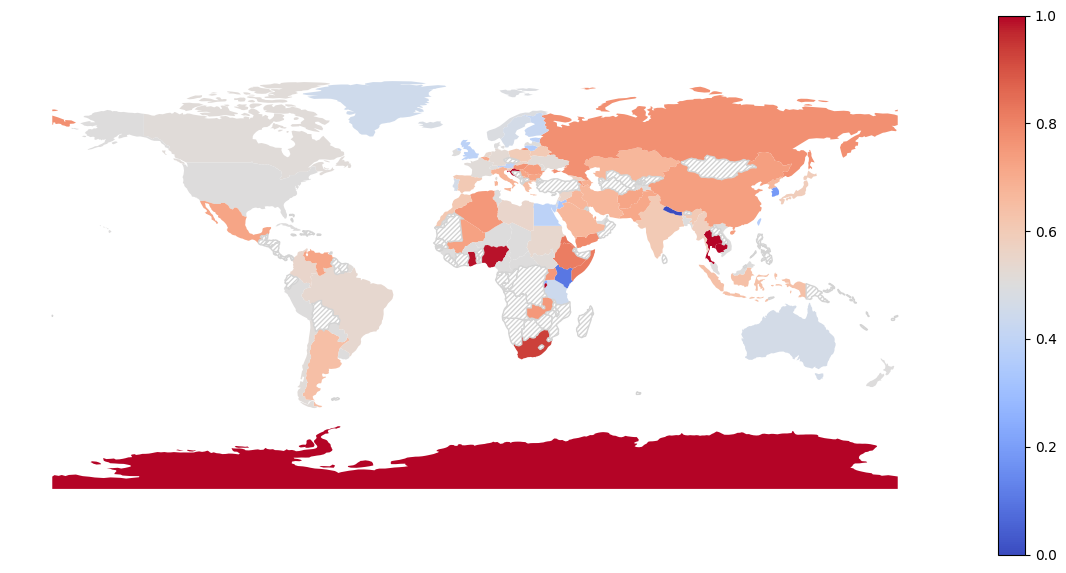

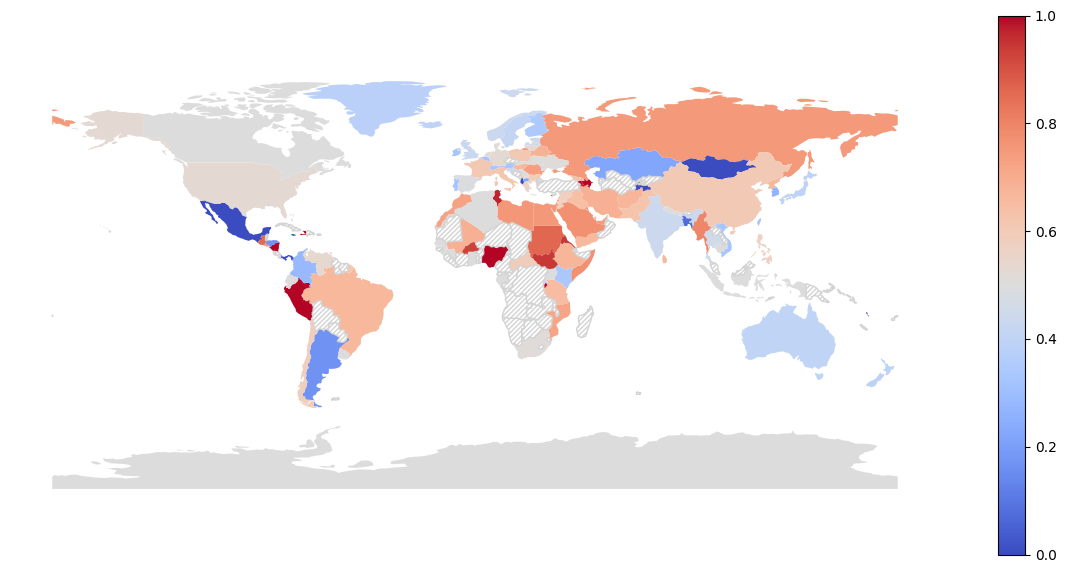

In [ ]:
df = pl.scan_parquet("../../data/edges")
df_w = pl.scan_parquet("../../data/wordcounts")
df_t = pl.scan_parquet("../../data/topics")
df_s = pl.scan_parquet("../../data/stances")
world = gpd.read_file("../../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
df = df.join(df_t.select("position", "topics"), on="position", how="left")
df = df.join(df_s.select("pos", "parsed_stance"), left_on="position",right_on="pos", how="left")
df = df.with_columns(pl.col("Date").str.to_date())
df = df.sort("Date", descending=False)
df = df.filter(pl.col("Party_orientation") != "-")
df = df.filter(pl.col("source_country").is_in(["NO","DK","FI","SE"]))
df = df.filter(pl.col("source_country").is_in(["FI"]))

df = df.with_columns(
    pl.col("parsed_stance")
    .replace({"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1,"": None})
    .cast(pl.Int16).alias("sentiment")
)

#print(df.collect())
df_right = df.filter((pl.col("Party_orientation").str.contains("[Rr]ight")))
df_left = df.filter((pl.col("Party_orientation").str.contains("[Ll]eft")))

createMap(group_y(df_right))
createMap(group_y(df_left))

#print(df_grouped.collect())


In [78]:
def createMap(df_m, country = None):
   df_m = df_m.group_by("target_country").agg(
        pl.col("avg_sentiment").mean().alias("avg_sentiment")
    )
   df_p = df_m.collect().to_pandas()
   df_p["avg_sentiment"]=(((df_p["avg_sentiment"] *-1) + 1) / 2)
   world_m = world.merge(df_p, left_on='ISO_A2_EH', right_on='target_country', how="left")
   #world_m = world_m.dropna()
   fig, ax = plt.subplots(1, 1, figsize=(15, 7))
   world_m.plot(column="avg_sentiment", ax=ax, legend=True, cmap='coolwarm', 
          missing_kwds={    
    "color": "white",
    "hatch": "///////",
    "edgecolor":"lightgrey",  # Diagonal stripes
    "label": "No data"})
   if country != None:
      country = world[world['ISO_A2_EH'] == selected_country]
      country.plot(ax=ax, color='red')
   ax.set_aspect('equal')
   #ax.set_title(f'Mentions by MPs from {world[world['ISO_A2_EH'] == selected_country]["NAME"].iloc[0]} in {date}', fontdict={'fontsize': 16})
   ax.set_axis_off()
   plt.show()

/tmp/ipykernel_5526/1476494568.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("GnBu")


ValueError: aspect must be finite and positive 

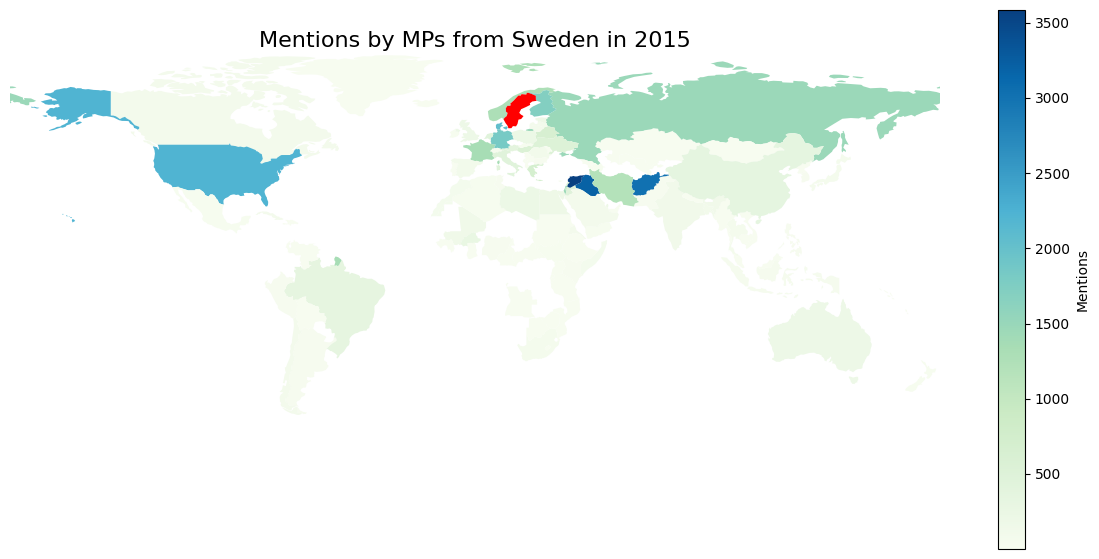

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors


cmap = cm.get_cmap("GnBu")
norm = colors.Normalize(vmin=world_m["len"].min(), vmax=world_m["len"].max())
xmin, ymin, xmax, ymax = world.total_bounds

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, ax=ax, label="Mentions")

country = world[world['ISO_A2_EH'] == selected_country]
country.plot(ax=ax, color='red')

def update(frame_date):
    ax.clear()

    world_m_a = world_m[world_m["Date"] == frame_date]

    world_m_a.plot(column='len', ax=ax, cmap='GnBu',legend=False, missing_kwds={"color": "lightgrey", "label": "No data"})

    country.plot(ax=ax, color='red')

    ax.set_aspect('equal')
    country_name = world[world['ISO_A2_EH'] == selected_country]["NAME"].iloc[0]
    ax.set_title(f'Mentions by MPs from {country_name} in {frame_date}', fontdict={'fontsize': 16})
    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


ani = FuncAnimation(fig, update, frames=date_range, repeat=False)

ani.save('mentions_animation.gif', writer='pillow', fps=1)  # Increase fps for faster playback
